In [91]:
# Importing modules used in the lecture
import numpy as np
from numpy import cos, sin, tan, pi, exp
import matplotlib.pyplot as plt
import scipy.signal as sig
from IPython.display import Audio

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

<img src="Figurer/NTNU_Logo.png" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Advanced applications of FIR filters

* **Course AIS2201 - Signal Processing**
* **Week 45, 2024**
* **Lecturer: Kai Erik Hoff**

# Topics:


* Mathematical models for signal distortion & disturbance
* About Wiener Filtering
    * Minimum Mean Square Error (MMSE)
    * Wiener filter as a tool for denoising
* Adaptive filters
    * Gradient Descent for finding MMSE
    * The LMS filter
    * Linear prodiction and noise filtering

# Signal distortion & noise

* A desired signal $s[n]$ is subjected to a distorting system $g[n]$, and subjected to interfering noise $v[n]$ before the sampled signal $x[n]$ is acquired.

<img src="figures/advanced_fir/distortion.png" align="center" style="width: 600px; margin-left:100px">


* Mathematical description:
### $$ x[n] = s[n] * g[n] + v[n]$$


* How can we attempt to extract the desired signal $s[n]$ from the sampled data $x[n]$?

## Example:

$$\begin{align}
x[n] &= s[n] + v[n] \\
s[n] &= \sin\left(\frac{\pi}{20} \cdot n \right) \\
v[n] &\sim \mathcal{N}(0, 1) 
\end{align}$$

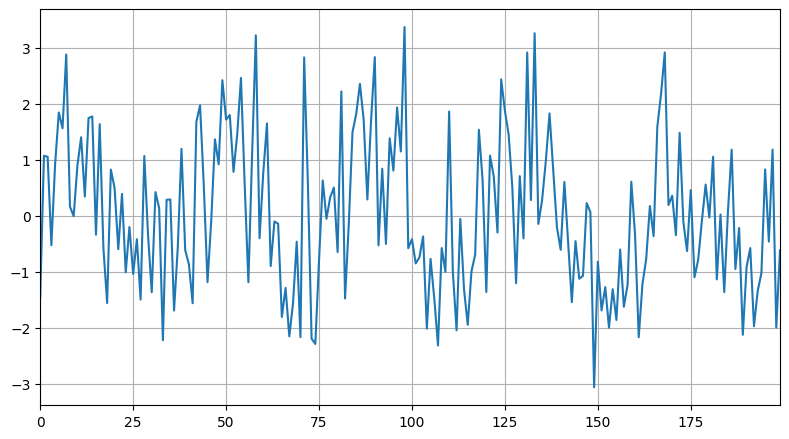

In [90]:
n = np.arange(200)
s = sin(pi/20*n)
v = np.random.normal(0, 1, size=200)
x = s + v
plt.plot(x)

# The Wiener Filter

* Aims to produce an estimate $\hat{s}[n] \approx s[n]$ by filtering the sampled data $x[n]$.

<img src="figures/advanced_fir/wiener.png" align="center" style="width: 600px; margin-left:100px">

* Deviation quantified as: $e[n] = \hat{s}[n]-s[n]$
    * In principle, $e[n] \rightarrow 0$ would imply perfect reconstruction

* But how is are the optimal filter coefficients identified?

# Mean squared error

<img src="figures/advanced_fir/MMSE.png" align="right" style="width: 600px">

* $e[n]=0$ not practically possible unless noise power also equals zero
* Mean Square Error (MSE)
$$E\left(|e[n]|^2\right) = E\left(|s[n] - h[n]*x[n]|^2\right)$$
    * Will be a quadratic funciton of filter impulse response vector $\vec{h} = [h[0], h[1], \ldots, h[M-1]]^T$
 
* Optimal filter $\vec{h}_{opt}$ identified by solving:
$$ \frac{\delta E\left(|e[n]|^2\right)}{\delta \vec{h}}=0 \tag{1}$$



# Solution:

* The solution for equation $1$ in the previous slide can be described in the frequency domain as:
$$H_{opt}(\hat{\omega}) = \frac{S_{xs}(\hat{\omega})}{S_{xx}(\hat{\omega})}$$
    * $S_{xx}(\hat{\omega})$ is the *power spectral density* of $x[n]$.
        * Equals the magnitude spectrum of the autocorrelation function: $S_{xx}(\hat{\omega}) = \text{DTFT}\left(r_{xx}(l)\right)$
    * $S_{xs}(\hat{\omega})$ is the *cross power spectral density* of $x[n]$ and $s[n]$.
        * Equals the magnitude spectrum of the cross correlation function: $S_{xs}(\hat{\omega}) = \text{DTFT}\left(r_{xs}(l)\right)$
    * The derivation of this solution is beyond the scope of the course.

## Denoising example I

* Estimate the frequency response best suited to reconstruct the signal $s[n] = \sin\left(2\pi \cdot 440 \cdot \frac{n}{f_s}\right)$ from a sampled signal $x[n] = s[n] + v[n]$ where $v[n]$ is White Gaussian Nise (WGN) with variance $\sigma_v^2 = 1$.
    * $f_s$ is 8000 samples/second.

In [92]:
# Signal generation
fs = 8000
t_n = np.linspace(0, 1, fs, endpoint=False)
s_n = np.sin(2*np.pi*440*t_n)
x_n = s_n + np.random.normal(loc=0, scale=1, size=fs)

Audio(x_n, rate=fs)

In [93]:
# Calculate wiener filter estimate
h_len = 256 # number of filter taps
f_filt, P_xx = sig.csd(x_n, x_n, fs=fs, nperseg=h_len, noverlap=h_len//2)
f_filt, P_xs = sig.csd(x_n, s_n, fs=fs, nperseg=h_len, noverlap=h_len//2)
H_filt = P_xs/P_xx
h = np.fft.irfft(P_xs/P_xx*np.exp(-2j*np.pi*f_filt/fs*((h_len-1)/2)), n=h_len)*sig.windows.hamming(h_len)

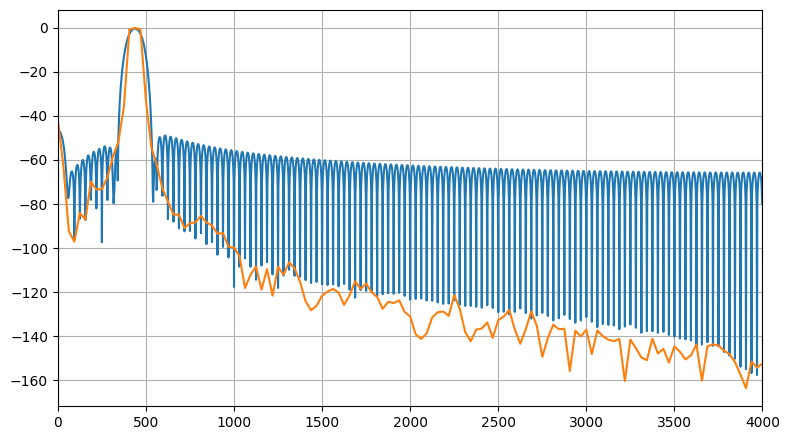

In [94]:
f_filt2, Hf_filt2 = sig.freqz(h, 1, fs=fs, worN = h_len*8)
plt.plot(f_filt2,20*np.log10( np.abs(Hf_filt2)))
plt.plot(f_filt,20*np.log10( np.abs(P_xs/P_xx)))
#f_welch, Hf_welch = sig.welch(x, fs=fs, window="hamming", nperseg=2048, noverlap=1024, nfft=2048)

In [95]:
y_n = np.convolve(x_n, h)
Audio(y_n, rate=fs)

# Expanded solution:
$$H_{opt}(\hat{\omega}) = \frac{G(-\hat{\omega}) \cdot S_{ss}(\hat{\omega})}{|G(\hat{\omega})|^2\cdot S_{ss}(\hat{\omega}) + S_{vv}(\hat{\omega})}$$

* Assumes signal $s[n]$ and noise $v[n]$ are uncorrelated (generally true)
* $S_{ss}(\hat{\omega})$ is the signal Power Spectral Density (PSD)
* $S_{vv}(\hat{\omega})$ is the noise Power Spectral Density (PSD)

# Uses:
1. System identification
    * $s[n]$ and $x[n]$ are known, $g[n]$ is unknown
    * Noise PDF is estimated/assumed
2. Deconvolution
    * $g[n]$ and $x[n]$ are known, $s[n]$ is unknown
    * Noise PDF is estimated/assumed
3. Denoising
    * $g[n]$ is known, or assumes $G(\hat{\omega}) = 1$
    * Noise PDF is estimated/assumed
    * $x[n]$ is known

## Denoising example II

* Without prior knowledge of $s[n]$, estimate a wiener filter design which will remove the noise. The noise signal $v[n]$ can be assumed to be white gaussian noise.
    * Assuming a narrowband signal buried in white noise, the PSD median can be used as an estimate for noise level.

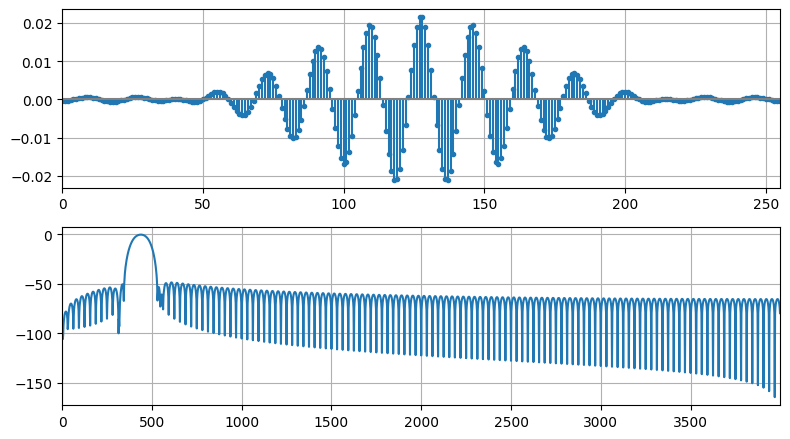

In [96]:
# Signal generation
fs = 8000
t_n = np.linspace(0, 1, fs, endpoint=False)
s_n = np.sin(2*np.pi*440*t_n)
x_n = s_n + np.random.normal(loc=0, scale=1, size=fs)

h_len = 256 # number of filter taps
f_filt, P_xx = sig.welch(x_n, fs=fs, nperseg=h_len, noverlap=h_len//2)  # Calculate PSD of x[n]

noise_floor = np.median(P_xx)  # Estimate noise level

P_vv = np.where(P_xx < noise_floor*1.5, P_xx, noise_floor)  # Separate noise PSD by setting a threshold for what constitutes a "signal"

P_ss = P_xx - P_vv  # Estimate PSD of s[n] by subtracting noise
H_filt = P_ss/(P_ss + P_vv)  # Calculate Wiener Filter Response H(f)
H_filt = H_filt * np.exp(-2j*np.pi*f_filt/fs*(h_len-1)/2)   # Add delay for causal filter
h_filt = np.fft.irfft(H_filt, n=h_len)  # Calculate desired filter frequency response
h_filt*= sig.windows.hamming(h_len)   # Apply window function
f_2, H_2 = sig.freqz(h_filt, 1, worN=8*h_len, fs=fs)  # Calculate acutal filter frequency response
plt.close(2); plt.figure(2)
plt.subplot(2,1,1)
plt.stem(h_filt, markerfmt='.', basefmt='grey')
plt.subplot(2,1,2)
plt.plot(f_2, 20*np.log10(np.abs(H_2)))

y_n = np.convolve(x_n, h_filt, mode="same")
Audio(y_n, rate=fs)

# Wiener filter limitations
* Assumes $x[n]$ can be modeled as a [Wide-Sense-Stationary](https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity) stochastic process. In simplified terms, this can be understood to mean:
    * Noise power $\sigma_v^2$ constant over the duration of the signal
    * The frequency content of $s[n]$ is constant over the duration of the signal
    * The distorting system $G(\hat{\omega})$ remains unchanged over the duration of the signal

#### Comments on calculating wiener filter coefficients

* Frequency-domain filter design as described above can be problematic due to the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon)
* Wiener filters more commonly designed by solving the [Wiener Hopf-equations](https://en.wikipedia.org/wiki/Wiener_filter#Finite_impulse_response_Wiener_filter_for_discrete_series), although this goes beyond the scope of this lecture.

# Adaptive filters

* Case: *Time-varying signal properties*
    * The properties $s[n]$, $g[n]$ and $v[n]$ may all be changing as time passes
    * Can we make a approximate Wiener filter which is capable of tracking this change?

# Adaptive filters: basic principle

<img src="figures/advanced_fir/adaptive_filter.png" align="center" style="width: 600px; margin-left:100px">

1. Filter a sampled signal $x[n]$ using a *instantaneous* filter impulse response $\vec{h}_n=\left[h[0], h[1], \ldots , h[M-1]\right]^T$ to produce an estimate $\hat{y}[n]$ of a desired output.
2. Calculate the error $e[n] = y[n] - \hat{y}[n]$
3. Use the error to update the next filter vector $\vec{h}_{n+1}$

# Configuring an adaptive filter as a predictor

<img src="figures/advanced_fir/prediction.png" align="center" style="width: 600px; margin-left:100px">

* With optimal prediction, $e[n]$ becomes white uncorrelated noise.
    * White noise is by nature not predictable.
* The output of the predictor $\hat{x}[n]$ will approach the remainder of the signal once white noise is removed.

## Prediction example
* Suggest a prediction filter impulse response $h[n]$ which can predict the next sample of a sinusoid which repeats every $8$ samples $\hat{\omega} = \frac{\pi}{4}$.
<img src="figures/advanced_fir/prediction_example.png" align="center" style="width: 700px; margin-left:100px">

# Gradient descent

* Iterative optimization algorithm, can find the local minimum of a function (e.g. $f(x) = (x-3)^2 + 2$)
    * Also works when $x$ is a vector of $N$ independent values
* Algorithm:
$$ \vec{x}_{n+1} = \vec{x}_n - \mu \nabla f(\vec{x}_n) $$
    * $\mu$ is the step size

#### Example:

In [16]:
# Run cell once to initialize
f = lambda x: (x-3)**2+2  # f(x)
df = lambda x: 2*(x-3)*1  # Derivative of f(x)

mu = 0.2  # step size

x_n = [0]   # Initial value

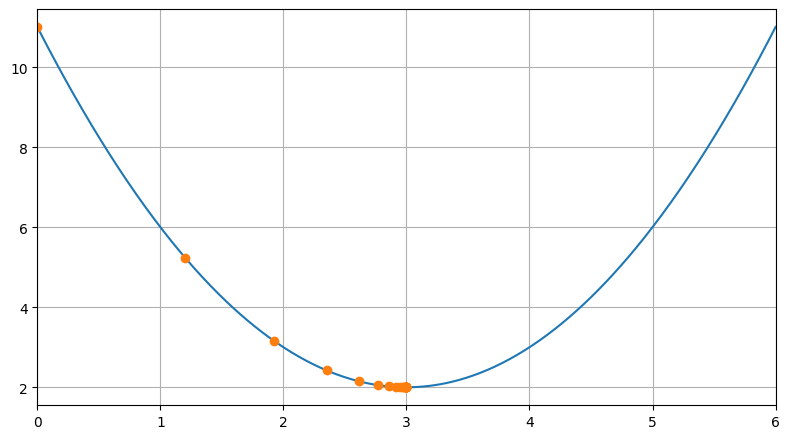

In [36]:
# Run repeatedly to observe gradient descent in 1D
x_next = x_n[-1] - mu*df(x_n[-1])
x_n.append(x_next)

x = np.linspace(0, 6, 501)
plt.plot(x, f(x))
plt.plot(x_n, f(np.array(x_n)), 'o')

## Gradient descent visualization for function of 2 variables

In [97]:
%%html
<iframe width="600" height="600" src="https://upload.wikimedia.org/wikipedia/commons/4/4c/Gradient_Descent_in_2D.webm"></iframe> 

# The Least Mean Squares (LMS) algorithm
* Gradient descent algorithm to find optimal filter coefficients $\vec{h}_{opt}$
    * Function to minimize: $E\left(|e[n]|^2 \right)\ \big| \ \vec{h} = F(\vec{h})$
    * Derivative of MSE: $\nabla F(\vec{h}) = -2\cdot e[n]\cdot \vec{h}_n$
 
* LMS Algorithm:
$$\vec{h}_{n+1} = \vec{h}_n + \mu \cdot 2 \cdot e[n] \cdot \vec{x}_n$$
where $\vec{x}_m$ is a vector of the $M$ most recent samples in reverse order: $\vec{x}_n = \left[x[n-1], x[n-2], \ldots , x[n-M]\right]^T$

* Each filter coefficient $h[k]$ in the vector $\vec{h}$ is a linearly independent variable of the squared error function
$$E\left(|e[n]|^2 \right) = E\left(|x[n]*h[n] - s[n]|^2 \right)$$

# LMS algorithm flowchart

<img src="figures/advanced_fir/prediction_flowchart.png" align="center" style="width: 500px; margin-left:200px">

## LMS example

* Use a LMS filter to filter the signal $x[n] = s[n] + v[n]$ where $s[n] = \sin\left(2\pi \cdot 440 \cdot \frac{n}{f_s}\right)$ and $v[n]$ is White Gaussian Nise (WGN) with variance $\sigma_v^2 = 1$.
    * $f_s$ is 8000 samples/second.
    * $\mu = 10^{-4}$


In [118]:
# Signal generation
fs = 8000
T = 1
t_n = np.linspace(0, T, T*fs, endpoint=False)
s_n = np.sin(2*np.pi*440*t_n)
noise_var = 0.1
x_n = s_n + np.random.normal(loc=0, scale=np.sqrt(noise_var), size=len(t_n))

Audio(x_n, rate=fs)

In [129]:
def FIR_lms(x, M, mu):
    h = np.zeros(M)  # Initial filter values
    y = np.zeros(len(x))
    err_log = np.zeros(len(x))
    
    for n in range(0, len(x)):
        n1 = max(n-M, 0)
        n2 = n
        x_indices = np.flip(np.arange(n1, n2))
        x_pred = np.sum(h[0:n2-n1]*x[x_indices])
    
        err = x[n]-x_pred
        h[0:n2-n1] += 2*mu*err*x[x_indices]
    
        y[n] = x_pred
        err_log[n] = err
    return y, err_log

y_n,_ = FIR_lms(x_n, M=256, mu=1e-4)

In [130]:
Audio(y_n, rate=fs)

## LMS Example part II

* Try out varying step sizes $\mu$ and compare the error power ($E(e^2[n])$) for the different step sizes.

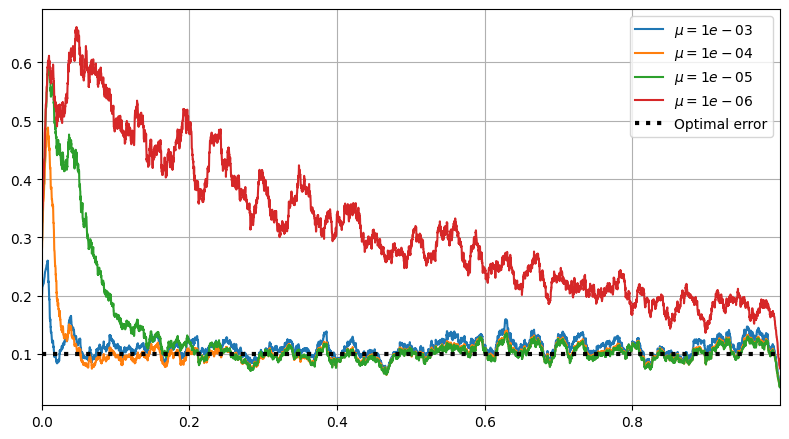

In [128]:
step_sizes = np.logspace(-3, -6, 4)

for step_size in step_sizes:
    y, e = FIR_lms(x_n, M=256, mu=step_size)
    plt.plot(t_n, np.convolve(e**2/1**2, np.ones(128)/128, mode="same"), label = f"$\\mu = {step_size:.0e}$")
    
plt.plot([t_n[0], t_n[-1]], noise_var*np.ones(2), ":k", linewidth=3, label="Optimal error")
plt.legend()

# LMS Filter step size considerations


* Large step size:
    1. Faster convergence with "optimal" filter coefficients
    2. Larger error values once filter has converged
    3. Potentially unstable!

* Small step size:
    1. Slower to converge with "optimal" filter coefficients
    2. May not be able to "keep up" with changes in a time-varying signal

* Overall:
    * Convergence speed / stability dependent by signal power!
$$P_x = E(x^2[n])$$

# The Normalized LMS filter

* Normalizes the input according to estimated signal power based on $M$ samples in filter state buffer:
$$\hat{P}_x[n] = \sum_{k=0}^{M-1}x^2[n-k]$$

* The normalized LMS algorithm:
$$\vec{h}_{n+1} = \vec{h}_n + \frac{\mu \cdot e[n] \cdot \vec{x}_n}{\alpha + \hat{P}_x[n]}$$
where $\mu$ is a static step size and $\alpha$ safeguards against dividing by zero.

* Stability criterion:
$$0 <\mu < 2$$

## LMS example part III

* Use a normalized LMS filter to filter the noisy sinusoid `x_n`, and try out different step sizes.

In [126]:

def FIR_lms_norm(x, M, mu, alpha=1):
    h = np.zeros(M)  # Initial filter values
    y = np.zeros(len(x))
    err_log = np.zeros(len(x))
    for n in range(0, len(x)):
        n1 = max(n-M, 0)
        n2 = n
        x_indices = np.flip(np.arange(n1, n2))
        x_pred = np.sum(h[0:n2-n1]*x[x_indices])
        x_pow = sum(x[x_indices]**2)
    
        err = x[n]-x_pred
        h[0:n2-n1] += mu*err*x[x_indices]/(alpha + x_pow)
    
        y[n] = x_pred
        err_log[n] = err
    return y, err_log

y_n, e_n = FIR_lms_norm(x_n, M = 256, mu=0.2) 
Audio(y_n, rate=fs)

# LMS Filter summary

* Self-tuning
    * Can adapt to signals whose frequency content changes with time

* Computationally simple
    * No matrix inversions or other problems which must be solved iteratively involved.

* Normalized LMS generally desirable
    * Automatically adjusts step size to signal power

## LMS on STM32
* Built-in functions included in the CMSIS-DSP library